# **Polar Express**
----------------
##### **Paolini Lorenzo** - Matricola n. 0001056503

The following notebook is divided into 4 different sections:
- **Section 1**: Definition of all the functions that will be used to build, train and evaluate the model. `polar_generator` is the default function, it has not been modified. In this section you will find the functions `compute_accuracy` (*useful to compute the accuracy of the model*), `plot_history` (*useful to plot the accuracy and loss lines during the training step*), and the two functions `earlystopping` and `reduce_lr` (both these functions are `callback` functions and are useful to, respectively, *stop the training process if the model stops learning*, and to *dynamically scale by a factor of* 0.1 *the learning rate of the model if there is the possibility that it is stuck in a plateau*);
- **Section 2**: Definition of the model, model summary, and hyperparameters settings;
- **Section 3**: Training process, history of training, accuracy and loss plots on validation set;
- **Section 4**: Contains the evaluation of the model done by the previously defined accuracy function. The function returns the total number of predictions done by the network, the number of correct predictions, the accuracy (in percentage) of the model, and whether it satisfies or not the basic requirement of a 95% accuracy.

<font color="red"><b><i>I have used the Flat variant of the generator by setting `flat=True` in all the instances of the generator</i></b></font>

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, concatenate, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras import callbacks
import matplotlib.pyplot as plt

## **Section 1**: Functions

#### Generator
It is the original generator, treated as a black box and not modified.

In [2]:
def polar_generator(batchsize,grid=(10,10),noise=.002,flat=False):
  while True:
    x = np.random.rand(batchsize)
    y = np.random.rand(batchsize)
    out = np.zeros((batchsize,grid[0],grid[1]))
    xc = (x*grid[0]).astype(int)
    yc = (y*grid[1]).astype(int)
    for b in range(batchsize):
      out[b,xc[b],yc[b]] = 1
    #compute rho and theta and add some noise
    rho = np.sqrt(x**2+y**2) + np.random.normal(scale=noise)
    theta = np.arctan(y/np.maximum(x,.00001)) + np.random.normal(scale=noise)
    if flat:
      out = np.reshape(out,(batchsize,grid[0]*grid[1]))
    yield ((theta,rho),out)

#### Visualization function

In [3]:
# Visualization of training parameters function
################################################################################

def plot_history(history):
    """
    plot_history takes in input the history record of the model
    It computes the accuracy line on validation set per epoch, and the loss line per epoch
    """
    print(history.history.keys())
    # summarize history for categorical_accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Accuracy function

In [4]:
# Accuracy function
################################################################################

def compute_accuracy(model, generator, test_sample_size):
    """
    The function takes in input the model, the generator, and the number of samples 
    you want to use to evaluate the accuracy of the model.
    """
    test_gen = polar_generator(batchsize=test_sample_size, grid=(10,10), flat=True)
    (theta, rho), maps = next(test_gen)
    pred = model.predict([theta, rho])
    n_correct_guess = 0
    for i, map in enumerate(pred):
      if np.argmax(map) == np.argmax(maps[i]):
          n_correct_guess+=1
    model_accuracy = 100*(n_correct_guess/len(maps))
    print("Over {} predictions done by the model,".format(len(maps)))
    print("The number of correct guesses is {}.".format(n_correct_guess))
    print("\n")
    print("Thus resulting in a {:.2f}% of accuracy.".format(model_accuracy))
    print("\n")
    if model_accuracy >= 95:
      basic_requirements = True
    else:
      basic_requirements = False
    print("The model {} satisfies the basic requirements: {}".format(model, basic_requirements))
    return basic_requirements

#### Callback functions
As specified in the introduction, this section contains the definition of 2 callback functions.

In [5]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 32, 
                                        restore_best_weights = True)

In [6]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                        patience=5, min_lr=0.000001)

## **Section 2**: Model

#### Model definition
I concatenated the two inputs (theta and rho), and used two Dense layers to process the coordinates. The two activation functions used for the dense layers are `swish` and `selu`. The output is processd by a final output layer, aimed to produce the probability mapping of the prediction thanks to the `softmax` function. </br>
The optimizer I have used is `Adam`, and I have set the initial learning rate to 0.1. Even though it is pretty high, I have noticed that, in particular during the first epochs, the model do not overfit, and the loss function, that has been initialized to the `categorical_crossentropy`, continues to decrease. Obviously, during training, the learning rate will decrease by a factor of 0.1, as defined in the `reduce_lr` callback function.

In [7]:
##################################
# Model Name = biDense_model
##################################

# Define optimizer and initial learning rate
optimizer = Adam(learning_rate=0.1)

# Define the inputs and concatenate them
theta = Input(shape=(1,))
rho = Input(shape=(1,))
concatenated_inputs = concatenate([theta, rho])

# Define first and second Dense layers
first_dense_layer = Dense(6, activation='swish')(concatenated_inputs)
second_dense_layer = Dense(2, activation = 'selu')(first_dense_layer)


# Output Dense layer
output = Dense(100, activation='softmax')(second_dense_layer)

# Build and compile the model
biDense_model = Model(inputs=[theta, rho], outputs=output)
biDense_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Now, I print on screen the summary of the model.

In [8]:
biDense_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 6)            18          ['concatenate[0][0]']        

#### Setting hyperparameters 

In [9]:
batchsize = 128
epochs = 200
steps_per_epoch = 2000 
validation_steps = 200 

## **Section 3**: Training and history

#### Training

Thanks to the `early_stopping` function, the model will stop training before overfitting or stopping to learn, this allow me to also restore the best weights. The number of epochs is too high, but it is not a problem since the model will stop before the end.

In [10]:
# Training record
################################################################################

history = biDense_model.fit(polar_generator(batchsize=batchsize, grid=(10,10), flat=True),
                              validation_data=polar_generator(batchsize=batchsize, grid=(10,10), flat=True), 
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=validation_steps, 
                              epochs=epochs,
                              shuffle=True, 
                              callbacks =[reduce_lr, earlystopping])

Epoch 1/200
2000/2000 [==============================] - 14s 6ms/step - loss: 1.8400 - categorical_accuracy: 0.4024 - val_loss: 1.3115 - val_categorical_accuracy: 0.5587 - lr: 0.1000
Epoch 2/200
2000/2000 [==============================] - 11s 6ms/step - loss: 1.1581 - categorical_accuracy: 0.6007 - val_loss: 1.0676 - val_categorical_accuracy: 0.6264 - lr: 0.1000
Epoch 3/200
2000/2000 [==============================] - 7s 3ms/step - loss: 0.9611 - categorical_accuracy: 0.6591 - val_loss: 0.9912 - val_categorical_accuracy: 0.6474 - lr: 0.1000
Epoch 4/200
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8497 - categorical_accuracy: 0.6947 - val_loss: 0.7535 - val_categorical_accuracy: 0.7361 - lr: 0.1000
Epoch 5/200
2000/2000 [==============================] - 6s 3ms/step - loss: 0.7856 - categorical_accuracy: 0.7159 - val_loss: 0.7875 - val_categorical_accuracy: 0.6941 - lr: 0.1000
Epoch 6/200
2000/2000 [==============================] - 6s 3ms/step - loss: 0.7333 - ca

#### History about accuracy on validation test, and plots

In [11]:
np.max(history.history["val_categorical_accuracy"])

0.9545312523841858

In [12]:
history.history["val_categorical_accuracy"]

[0.5586718916893005,
 0.6264452934265137,
 0.6474218964576721,
 0.736132800579071,
 0.6941015720367432,
 0.7054687738418579,
 0.6849609613418579,
 0.7362499833106995,
 0.7813671827316284,
 0.7794530987739563,
 0.761914074420929,
 0.7916796803474426,
 0.8164843916893005,
 0.6950390338897705,
 0.8243359327316284,
 0.7869921922683716,
 0.7594531178474426,
 0.7901562452316284,
 0.7716015577316284,
 0.8157812356948853,
 0.8137890696525574,
 0.8363671898841858,
 0.8189062476158142,
 0.8140234351158142,
 0.8112499713897705,
 0.787890613079071,
 0.8248046636581421,
 0.9175390601158142,
 0.9207422137260437,
 0.9306640625,
 0.8973827958106995,
 0.9317578077316284,
 0.9240624904632568,
 0.927734375,
 0.9345703125,
 0.9329687356948853,
 0.9110156297683716,
 0.9171484112739563,
 0.9232812523841858,
 0.9266015887260437,
 0.9320703148841858,
 0.9303125143051147,
 0.9267187714576721,
 0.9130077958106995,
 0.9267968535423279,
 0.9161718487739563,
 0.9300781488418579,
 0.9200390577316284,
 0.93199217319

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


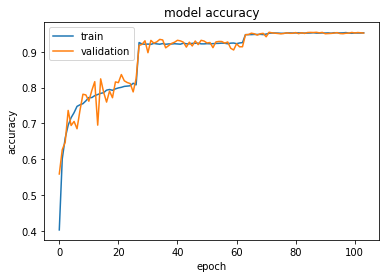

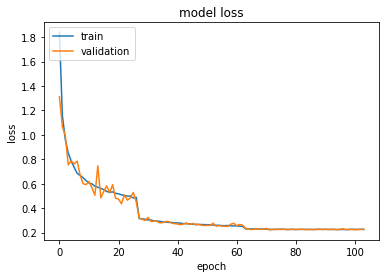

In [13]:
plot_history(history)

## **Section 4**: Evaluation of the model

The evaluation has been done on: **200000** samples

In [16]:
compute_accuracy(biDense_model, polar_generator, 200000)

6250/6250 [==============================] - 9s 1ms/step
Over 200000 predictions done by the model,
The number of correct guesses is 191183.


Thus resulting in a 95.59% of accuracy.


The model <keras.engine.functional.Functional object at 0x7f7f76db5610> satisfies the basic requirements: True


True